# Training a VAE on MNIST
Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

    Navigate to Edit→Notebook Settings
    select GPU from the Hardware Accelerator drop-down
    
You can check if the GPU works with nvidia-smi.


## Data loading
Let's import some libraries and load the MNIST dataset.

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import IPython.display
import numpy as np

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


## Architecture specification

You can use the following encoder (don't forget that in a VAE the decoder has two heads, for the mean and the variance):
```
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
```
and this decoder:
```
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
```
Then, you need to complete the forward function. You can use Relu activations for every layers except for the heads that can reach negative values. Concerning the decoder head, you can use sigmoid to obtain values in [0,1].

Here we consider a latent space of dimension 2 but is could be any *zdim* dimension.

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        self.x_dim = x_dim 
        self.h_dim1 = h_dim1
        self.h_dim2 = h_dim2
        self.z_dim = z_dim 

        # encoder part
        #self.fc1 = # ...
        self.fc1 = torch.nn.Linear(x_dim, h_dim1, )
        self.fc2 = torch.nn.Linear( h_dim1,  h_dim2)
        self.fc3_mu = torch.nn.Linear( h_dim2,  z_dim)
        self.fc3_var = torch.nn.Linear( h_dim2,  z_dim)

        # decoder part
        self.fc4 = torch.nn.Linear( z_dim, h_dim2) # ...
        self.fc5 = torch.nn.Linear( h_dim2, h_dim1)
        self.fc6 = torch.nn.Linear( h_dim1, x_dim)  

    def encoder(self, x):
        # ...
       # print(x.shape)
       # print(self.x_dim)
        output = F.relu(self.fc1(x))
        output = F.relu(self.fc2(output))
        mu = self.fc3_mu(output)
        log_var = self.fc3_var(output)
        return mu, log_var # returns mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std) # std is used only for its dimensions
        z = eps.mul(std).add_(mu)
        return z # ... return z sample
        
    def decoder(self, z):
        # ...
        output = F.relu(self.fc4(z))
        output = F.relu(self.fc5(output))
        output = F.sigmoid(self.fc6(output))
        return output # ...


    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784)) # ...
        z = self.sampling(mu, log_var)
        image_rec = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var
      #  z = self.sampling(mu, log_var)
       # image_rec= self.decoder(z)# ...
        #return image_rec, mu, log_var


## Loss function
The total loss of the VAE is composed of two terms: a reconstruction term and the KL divergence with the Prior. The KL divergence between two gaussians is given by:

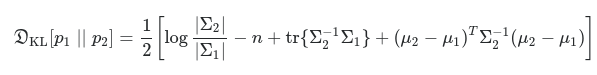

Assuming a unit gaussian as prior, we obtain a very simple equation that will help you to implement it in pytorch:

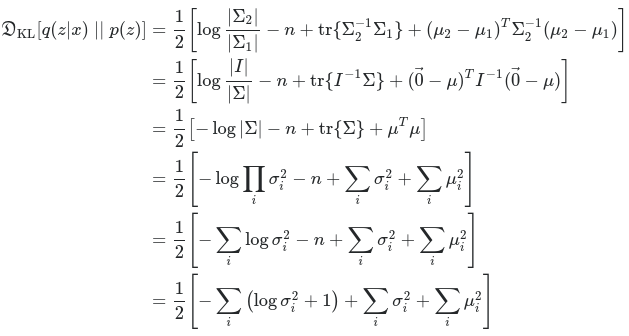

Note that, in these equations sigma denotes the standard deviation while the encoder network ouputs the log of the variance.  

In [ ]:
# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()
optimizer = optim.Adam(vae.parameters())

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    RecLoss = F.mse_loss (recon_x, x.view(-1, 784), reduction = "sum")# ...
    KLDLoss =  -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # ...
    return RecLoss + KLDLoss

## Training step
In this cell, we define the function that performs training on one epoch. We recommend to debug it using the "main loop" cell later in the page.

In [ ]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        # ...
        recon_x, mu, log_var = vae(data)
        loss = loss_function(recon_x, data, mu, log_var) # ....view(-1, 784)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

## Visualization:
We provide some visualization functions:

In [ ]:
# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(generatedImages,dim=(10, 10), figsize=(10, 10)):
    generatedImages=generatedImages.cpu().numpy()
    print(generatedImages.shape)
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(np.squeeze(generatedImages[i]), interpolation='nearest', cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    #plt.savefig('gan_generated_image_epoch_%d.png' % epoch)
    IPython.display.display(IPython.display.Image(data=('gan_generated_image_epoch_%d.png' % epoch)))


## Test
Complete the test function that generate new sample from latent space samples. 

In [ ]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data) # ...
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var)# ...
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    with torch.no_grad():
      z = torch.randn(64, 2).cuda()
      generated = vae.decoder(z).cuda()# ...
      plotGeneratedImages(generated.view(generated.size(0), 1, 28, 28))
      #save_image(sample.view(64, 1, 28, 28), '.sample_' + '.png')

## Main loop

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 33.325898
Train Epoch: 1 [10000/60000 (17%)]	Loss: 32.589917
Train Epoch: 1 [20000/60000 (33%)]	Loss: 33.866851
Train Epoch: 1 [30000/60000 (50%)]	Loss: 33.245676
Train Epoch: 1 [40000/60000 (67%)]	Loss: 35.100178
Train Epoch: 1 [50000/60000 (83%)]	Loss: 33.026147
====> Epoch: 1 Average loss: 33.2774
Train Epoch: 2 [0/60000 (0%)]	Loss: 30.361123
Train Epoch: 2 [10000/60000 (17%)]	Loss: 33.672456
Train Epoch: 2 [20000/60000 (33%)]	Loss: 34.769946
Train Epoch: 2 [30000/60000 (50%)]	Loss: 35.587793
Train Epoch: 2 [40000/60000 (67%)]	Loss: 34.058687
Train Epoch: 2 [50000/60000 (83%)]	Loss: 34.861057
====> Epoch: 2 Average loss: 33.2644
Train Epoch: 3 [0/60000 (0%)]	Loss: 34.066191
Train Epoch: 3 [10000/60000 (17%)]	Loss: 33.046797
Train Epoch: 3 [20000/60000 (33%)]	Loss: 33.516714
Train Epoch: 3 [30000/60000 (50%)]	Loss: 32.539355
Train Epoch: 3 [40000/60000 (67%)]	Loss: 34.113901
Train Epoch: 3 [50000/60000 (83%)]	Loss: 34.872776
====> Epoch: 3 Average 

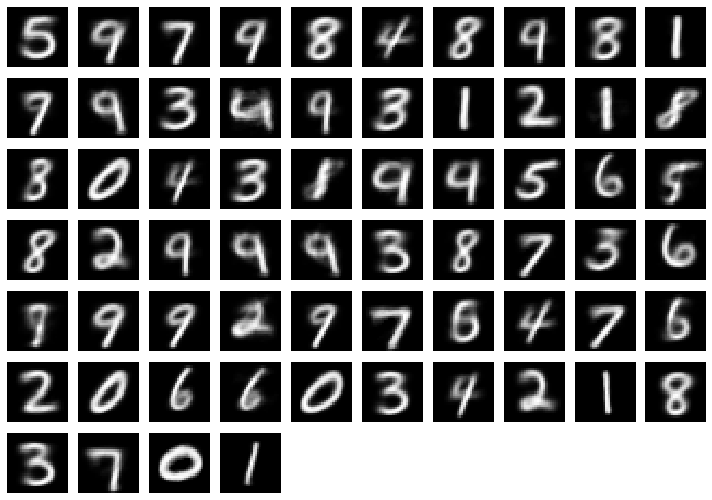

In [ ]:
for epoch in range(1, 5):
    train(epoch)
test()

## Bonus 1: Interpolation
Sample two latent vectors z1 and z2 and generate the corresponding images. Then, generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


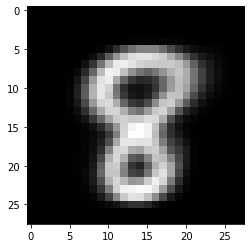

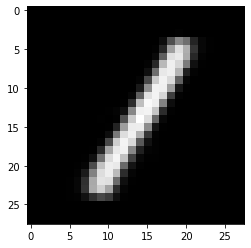

In [ ]:
# Sample 2 latent vectors
z1 = torch.randn(1, 2).cuda()
z2 =  torch.randn(1, 2).cuda()

# Generate corresponding images 
generated_1 = vae.decoder(z1).cuda()
generated_2 = vae.decoder(z2).cuda()

# Show images 
plt.imshow(generated_1.view(28,28).cpu().detach().numpy(), cmap = "gray")
plt.show()
plt.imshow(generated_2.view(28,28).cpu().detach().numpy(), cmap = "gray")
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


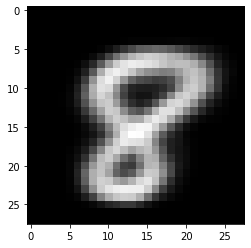

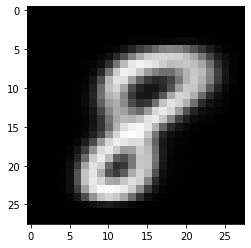

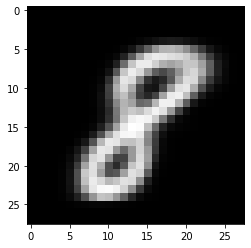

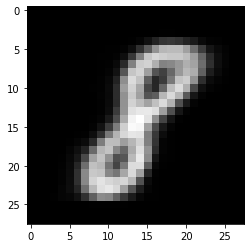

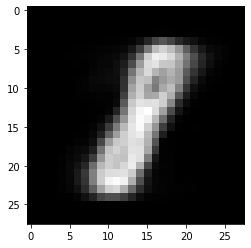

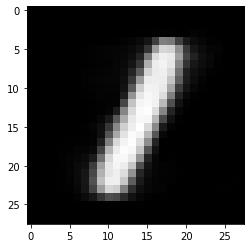

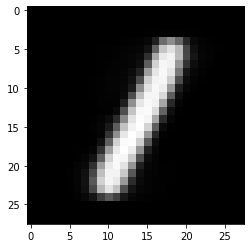

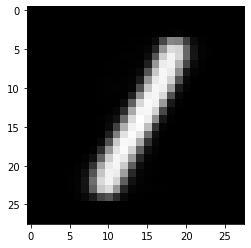

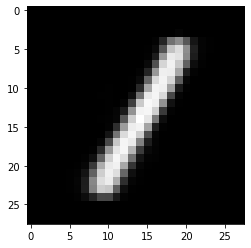

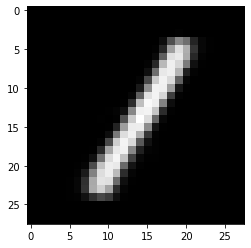

In [ ]:
# generate 10 intermediate images by performing linear interpolation in the latent space between the z1 and z2.
for i in range(10):
  interpolation = torch.lerp(z1, z2, (i+1)/10)
  generated = vae.decoder(interpolation)#.detach()
  
  plt.imshow(generated.view(28,28).cpu().detach().numpy(), cmap = "gray")
  plt.show()

## Bonus 2: Visualization
Generate a 10x10 mosaic by sampling *z* over a regulargrid in [-1,1]x[-1,1]. What do you observe? 


In [ ]:
x = np.linspace(-1, 1, 10)
y = np.linspace(-1, 1, 10)

In [ ]:
grid = torch.FloatTensor(len(x), len(y), 2)
#grid

In [ ]:
grid.shape

torch.Size([10, 10, 2])

In [ ]:
for i, lx in enumerate(x):
  for j, ly in enumerate(y):
    grid[j, i, 0] = lx
    grid[j, i, 1] = ly

In [ ]:
from torchvision.utils import make_grid

In [ ]:
# Flatten the grid
grid = grid.view(-1, 2)
grid = grid.cuda()

In [ ]:
reconstructions = vae.decoder(grid).view(-1, 1, 28, 28)
reconstructions = reconstructions.cpu()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
#reconstructions.shape

In [ ]:
#reconstructions.data.shape

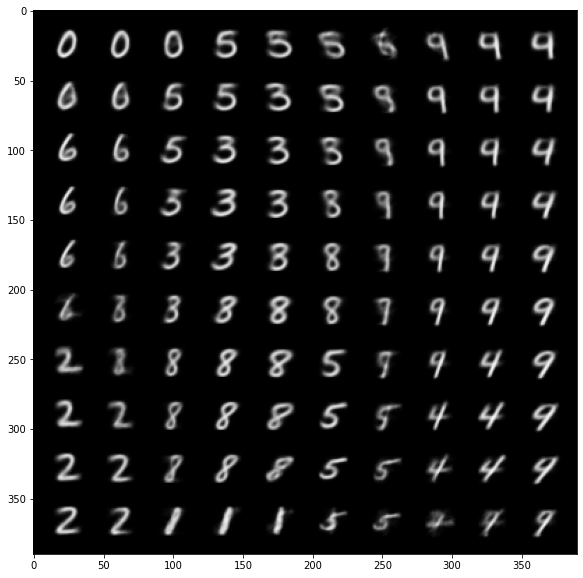

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(np.transpose(make_grid(reconstructions.data[:100], 10, 10).clamp(0, 1).numpy(), (1, 2, 0))) ;

- We can reconstruct the path of numbers found between the two numbers generated earlier. 
- There is a smooth evolution in images between numbers. 
